In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,ShuffleSplit


from sklearn.decomposition import PCA

plt.rcParams.update({'font.size':14})
plt.rcParams.update({"font.family" : "Times new roman"})

# Divide the dataset into Train-test split  and do the standard scalling

In [44]:
def split_transform(df,split_ratio):
    X=df.iloc[:,1:-1]
    Y=df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=split_ratio,shuffle=True)

    scaler=StandardScaler()
    X_sc_train = scaler.fit_transform(X_train)
    X_sc_test = scaler.transform(X_test)

    print("The number of samples in the Training set is {}".format(len(X_sc_train)))
    print("The number of samples in the Test set is {}".format(len(X_sc_test)))
    
    return  X_sc_train, X_sc_test,y_train,y_test,scaler

# Import Datasets

In [127]:
df=pd.read_csv(r'H:\Solar_panel_IFD\PreProcessed Data\Max_solar_data.csv')
#df2=pd.read_csv(r'H:\Solar_panel_IFD\PreProcessed Data\Lim_solar_data.csv')
  
#df = pd.concat([df1,df2], ignore_index=True, axis=0)

df.head()

,Time,Ipv,Vpv,Vdc,ia,ib,ic,va,vb,vc,Iabc,If,Vabc,Vf,label
0,0.000041,2.369843,90.429688,147.949219,0.616820,-0.530396,-0.160283,-146.003418,120.255127,25.595601,1.000000,50.000000,1.000000,50.000000,F0M
1,0.010040,2.378357,90.368652,148.242188,-0.678956,0.570679,0.047847,148.546906,-119.881439,-24.723663,1.000000,50.000000,1.000000,50.000000,F0M
2,0.020039,2.373627,90.460205,148.535156,0.603393,-0.537109,-0.187139,-145.027008,120.315399,26.109924,1.000000,50.000000,1.000000,50.000000,F0M
3,0.030038,2.368896,90.423584,148.242188,-0.685670,0.570679,0.041133,147.341461,-119.736786,-26.105906,0.440380,50.078491,118.275197,49.921509,F0M
4,0.040037,2.362274,90.435791,148.242188,0.630248,-0.523682,-0.166997,-143.279114,120.942230,26.680501,0.618996,50.248673,90.022162,49.606494,F0M


# Auto Encoder

![Drag Racing](https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/04/29202749/Blog_info_29-04-2020-R-02-1024x522.png)

In [128]:
df['label'].unique()

array(['F0M', 'F1M', 'F2M', 'F3M', 'F4M', 'F5M', 'F6M', 'F7M'],
      dtype=object)

In [110]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from tensorflow.keras.models import load_model

In [111]:
from tensorflow.keras.optimizers import Adam

In [114]:
X_sc_train, X_sc_test,y_train,y_test,scaler = split_transform(df,split_ratio=0.01)

The number of samples in the Training set is 10593
The number of samples in the Test set is 108


In [131]:
X_sc_train

array([[ 0.0688757 ,  0.4697652 ,  0.32281241, ...,  0.14963814,
         0.04016102,  0.57208114],
       [ 0.25120077,  0.2280872 ,  0.36271588, ...,  0.08270349,
         0.08823427, -0.34192729],
       [ 0.3407058 ,  0.43438008,  0.30685102, ...,  0.11994445,
         0.13529216,  0.07240802],
       ...,
       [-3.65884316, -3.13037048, -0.6109288 , ...,  0.04717247,
         0.01958734,  0.00927573],
       [ 0.42855333,  0.16790841,  0.34675449, ...,  0.1231137 ,
         0.07788997, -0.01648375],
       [ 0.6257959 ,  0.37949702,  0.30685102, ...,  0.07634089,
        -0.03864195, -0.53111227]])

In [129]:
n_inputs=X_sc_train.shape[1]

In [116]:
n_inputs

13

In [132]:

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(200,activation='relu')(visible)
e = Dense(100,activation='relu')(e)
e = Dense(50,activation='relu')(e)


# bottleneck
n_bottleneck = 2
bottleneck = Dense(n_bottleneck)(e)


# define decoder, level 1
d = Dense(50,activation='relu')(bottleneck)
d = Dense(100,activation='relu')(d)
d = Dense(200,activation='relu')(d)


# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')

model.summary()



Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               2800      
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_62 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 102       
_________________________________________________________________
dense_64 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_65 (Dense)             (None, 100)             

In [133]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_sc_train, X_sc_train, epochs=150, batch_size=2000, verbose=2, validation_data=(X_sc_test,X_sc_test),shuffle=True)
#After training, we can plot the learning curves for the train and test sets to confirm the model learned the reconstruction problem well.

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# save the encoder to file
encoder.save(r'H:\Solar_panel_IFD\Trained_model\encoder.h5')

Epoch 1/150
6/6 - 0s - loss: 0.8650 - val_loss: 0.3705
Epoch 2/150
6/6 - 0s - loss: 0.5804 - val_loss: 0.2678
Epoch 3/150
6/6 - 0s - loss: 0.4948 - val_loss: 0.2057
Epoch 4/150
6/6 - 0s - loss: 0.4123 - val_loss: 0.1911
Epoch 5/150
6/6 - 0s - loss: 0.3404 - val_loss: 0.1457
Epoch 6/150
6/6 - 0s - loss: 0.2683 - val_loss: 0.1124
Epoch 7/150
6/6 - 0s - loss: 0.2330 - val_loss: 0.0872
Epoch 8/150
6/6 - 0s - loss: 0.1909 - val_loss: 0.0878
Epoch 9/150
6/6 - 0s - loss: 0.1479 - val_loss: 0.0668
Epoch 10/150
6/6 - 0s - loss: 0.1301 - val_loss: 0.0644
Epoch 11/150
6/6 - 0s - loss: 0.1210 - val_loss: 0.0566
Epoch 12/150
6/6 - 0s - loss: 0.1088 - val_loss: 0.0505
Epoch 13/150
6/6 - 0s - loss: 0.0985 - val_loss: 0.0478
Epoch 14/150
6/6 - 0s - loss: 0.0914 - val_loss: 0.0448
Epoch 15/150
6/6 - 0s - loss: 0.0846 - val_loss: 0.0422
Epoch 16/150
6/6 - 0s - loss: 0.0842 - val_loss: 0.0498
Epoch 17/150
6/6 - 0s - loss: 0.0800 - val_loss: 0.0411
Epoch 18/150
6/6 - 0s - loss: 0.0731 - val_loss: 0.0411
E

Epoch 147/150
6/6 - 0s - loss: 0.0103 - val_loss: 0.0095
Epoch 148/150
6/6 - 0s - loss: 0.0103 - val_loss: 0.0089
Epoch 149/150
6/6 - 0s - loss: 0.0113 - val_loss: 0.0091
Epoch 150/150
6/6 - 0s - loss: 0.0114 - val_loss: 0.0089


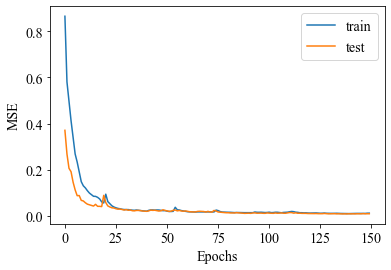

In [134]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [135]:
X_train_reconstructed = model.predict(X_sc_train)

In [138]:
X_sc_train.shape

(10593, 13)

In [136]:
X_train_reconstructed.shape

(10593, 13)

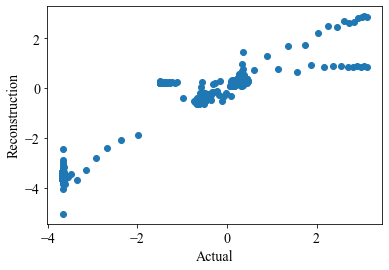

In [141]:
plt.scatter(X_sc_train[:,i],X_train_reconstructed[:,i])
plt.xlabel("Actual")
plt.ylabel("Reconstruction")
plt.show()

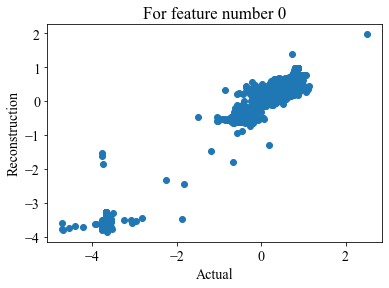

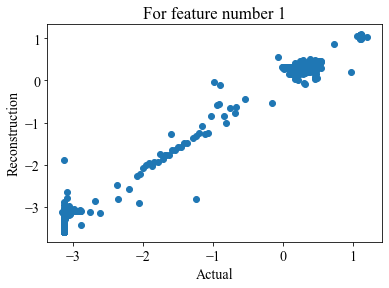

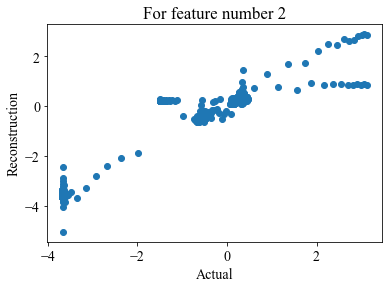

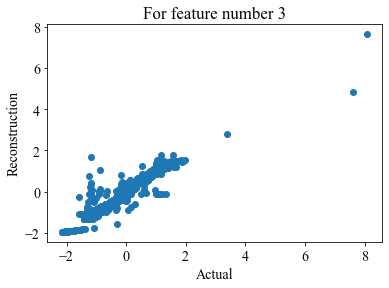

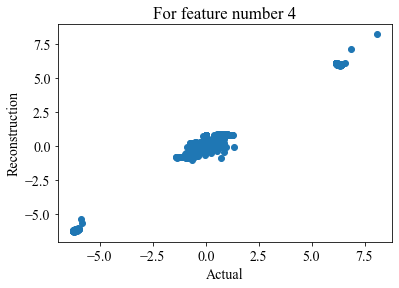

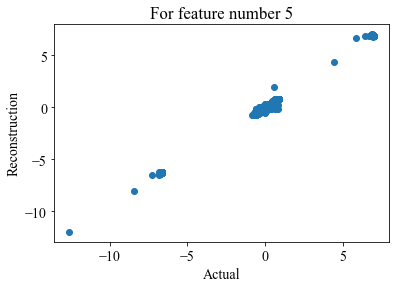

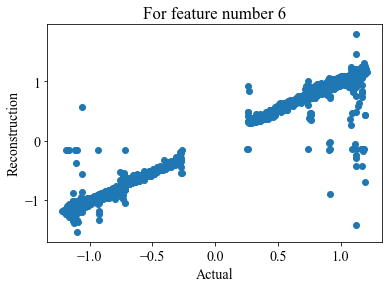

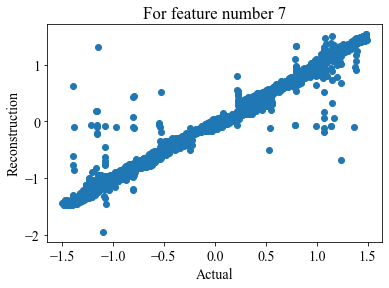

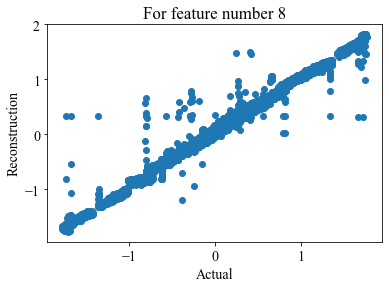

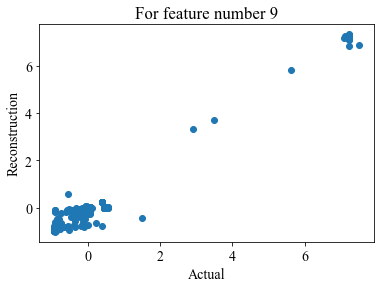

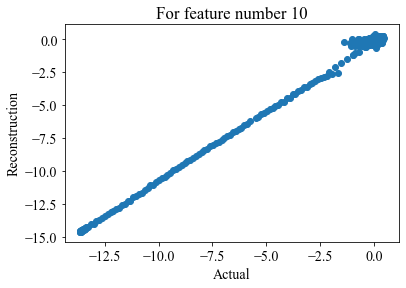

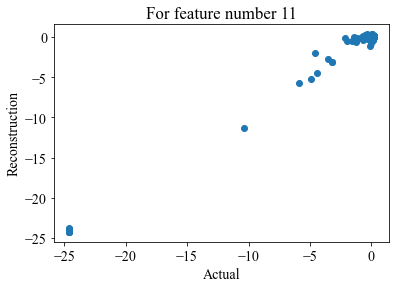

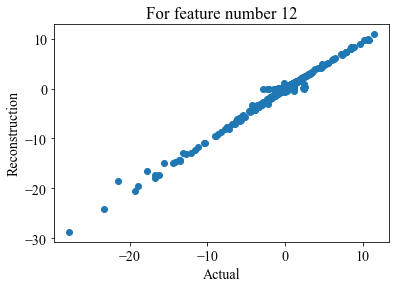

In [142]:

%matplotlib inline
plt.rcParams.update({'font.size':14})
plt.rcParams.update({"font.family" : "Times new roman"})


for i in range (X_sc_train.shape[1]):
    plt.scatter(X_sc_train[:,i],X_train_reconstructed[:,i])
    plt.title('For feature number {}'.format(i))
    plt.xlabel("Actual")
    plt.ylabel("Reconstruction")
    plt.show()

# Using only the Encoder part for dimentionality reduction.

In [143]:
# load the model from file
#encoder = load_model(r'H:\Solar_panel_IFD\Trained_model\encoder.h5')

# encode the train data
X_sc_train_encode = encoder.predict(X_sc_train)
# encode the test data
X_sc_test_encode = encoder.predict(X_sc_test)

In [144]:
X_sc_train_encode.shape

(10593, 2)

# Plotting the reduced dimentionality data with corresponding fault labels

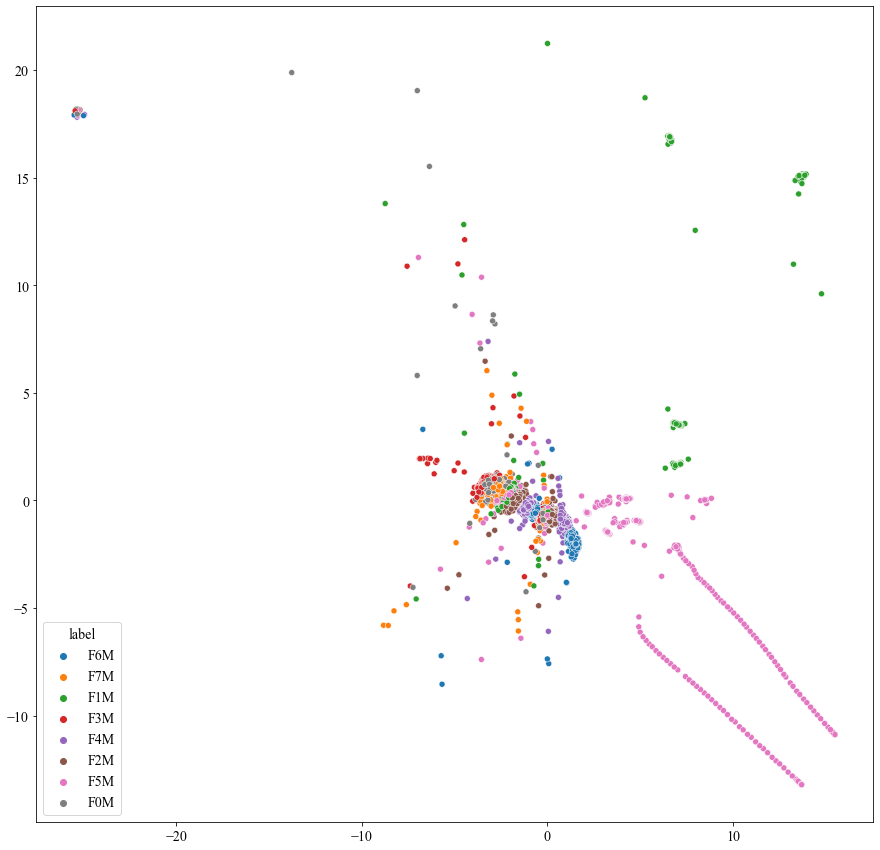

In [145]:
fig=plt.figure(figsize=(15,15))
sns.scatterplot(x=X_sc_train_encode[:,0],y=X_sc_train_encode[:,1],hue=y_train)
plt.show()

# Using The Reduced 2D data for prediction

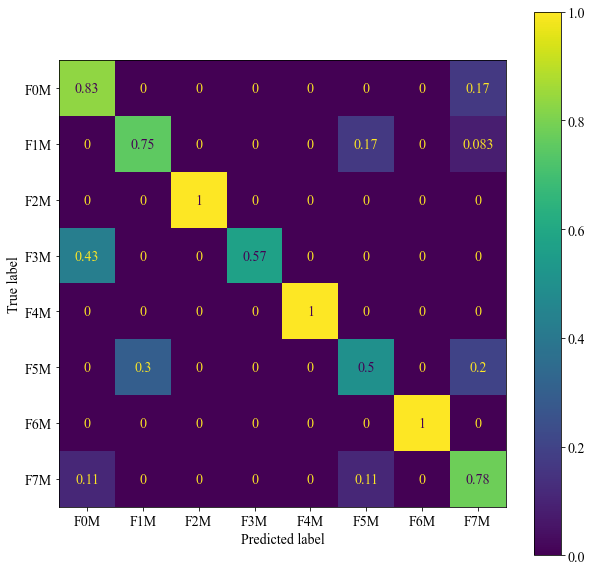

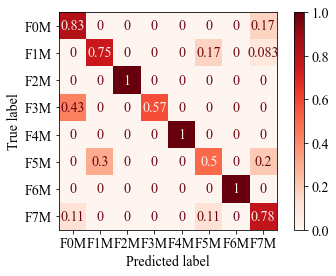

In [146]:
# X_sc_train, X_sc_test,y_train,y_test,scaler = split_transform(df,split_ratio=0.3)

Clf = RandomForestClassifier()
Clf.fit(X_sc_train_encode,y_train)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_estimator(
    Clf,
    X_sc_test_encode,
    y_test,
    display_labels=Clf.classes_,
    cmap=plt.cm.Reds,
    normalize='true'
)


disp.plot(ax=ax)
plt.show()